In [1]:
import numpy as np
import pymc3 as pm
from scipy import stats
from custom_metrics import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import Image, display
from scipy.special import gammaln ,digamma
from tqdm import tqdm
import sys

<h1><center>A Probabilistic Model for "Yes" or  "No" Queries:  
Crowdsourcing Multi-Class Classification Tasks </center></h1> 
<h2><center>Compare to Standard Complete ABCD question type</center></h2>

**1. Select the folder data:**

In [2]:
selected_folder = './catalina/'

**2. Load the data:**

In [3]:
# users + number of YN question selected for them as.
info_experts = pd.read_csv(selected_folder+'users.csv') 

In [4]:
# responses for the YN queries
votes = pd.read_csv(selected_folder+'votes_yn.csv') 

# objects to be classified
objects = pd.read_csv(selected_folder+'objects.csv')
# picking only object which were asked for both query types
objects = objects[objects._abc | objects._training]

# users + number of YN question selected for them as.
info_experts = pd.read_csv(selected_folder+'users.csv') 
info_experts = info_experts.set_index('id')

In [5]:
print("Training set size {}".format(objects._training.sum()))
print("Testing set size {}".format(objects._validation.sum()))
print("Number of objecs required ABCD and YN votes {}".format(objects._abc.sum()))

Training set size 41
Testing set size 80
Number of objecs required ABCD and YN votes 80


In [6]:
# Selecting the users who complete at least 70% of their contest's questions:
number_of_given_answers = dict(votes.expert_id.value_counts())
info_experts['percentage_done'] = 0
for key in number_of_given_answers:
    _total_question_created_for_this_expert = float(info_experts.loc[key].initial_yn_questions)
    info_experts.loc[key].percentage_done = float(number_of_given_answers[key])/_total_question_created_for_this_expert
info_experts = info_experts.reset_index()
info_experts = info_experts[info_experts.percentage_done >= .7]

**3 .Selecting data for running the model:**

In [7]:
# Selected annotators
experts = info_experts.id.values

# Filtering the votes
votes = votes[votes.expert_id.isin(experts)]

o_columns = objects[['catalina_id','Var_Type','_training','_validation']]

In [8]:
experts, experts.shape[0]

(array([19, 10,  9, 12,  6,  4, 13, 14]), 8)

In [9]:
o_columns.Var_Type.unique()

array(['CEP', 'EB', 'LPV', 'RRLYR'], dtype=object)

In [10]:
# Number of possible classes
K = o_columns.Var_Type.unique().shape[0]

# Number of annotators
J = experts.shape[0]

# Fit the annotators id with a sequential number
inv_experts_id = dict(zip(experts, range(J)))

# Fit the classes names with a sequential number
classes_dict = dict(zip(range(K),list(o_columns.Var_Type.unique())))
inv_classes_dict = {classes_dict[a]:a for a in classes_dict}

# I. Data Training Credibility Stage

In [11]:
# Getting the true classes' dirstribution
Ns_dict = dict(o_columns[o_columns._training].Var_Type.value_counts())
Ns = np.array([Ns_dict[classes_dict[i]] for i in classes_dict])
N = np.sum(Ns)

# Getting the true proportion classes' dirstribution
p = Ns / N

# LABELS GROUND TRUTH - TRAINING SET
zt = np.array([inv_classes_dict[_] for _ in o_columns[o_columns._training].Var_Type])

In [12]:
# Generatting the r matrix of votes from the source data
def matrix_votes(J, N, M, o_columns, votes):
    r_ = np.zeros((J, N, M, 2))
    for i in range(o_columns.shape[0]):
        instance = o_columns.iloc[i]
        _votes = votes[votes.object_id == instance.catalina_id]
        for v in range(_votes.shape[0]):
            vote = _votes.iloc[v]
            r_[inv_experts_id[vote.expert_id], i,  inv_classes_dict[vote.question], 1-vote.value] = 1
    return r_

In [13]:
# Getting the votes for the users KNOWN LABELS - TRAINING PART
r_true = matrix_votes(J, N, K, o_columns[o_columns._training], votes)  

# II. Data Testing Labeling Stage

In [14]:
# Getting the true classes' dirstribution
Ns_test_dict = dict(o_columns[~o_columns._training].Var_Type.value_counts())
Ns_test = np.array([Ns_test_dict[classes_dict[i]] for i in classes_dict])
N_test = Ns_test.sum()

# Getting the true proportion classes' dirstribution
p_test = Ns_test/N_test

# LABELS GROUND TRUTH - TESTING SET
zt_test = np.array([inv_classes_dict[_] for _ in o_columns[~o_columns._training].Var_Type])

In [15]:
# Getting the votes for the users UKNOWN LABELS - TESTING PART
r_test = matrix_votes(J, N_test, K, o_columns[~o_columns._training], votes)  

# III. YN - PYMC IMPLEMENTATION

### III. a) YN implementation - Credibility

In [16]:
ALPHA = .5
BETA = .5

with pm.Model() as model: 
    
    theta = pm.Beta('theta', alpha=ALPHA, beta=BETA, shape=(J, K, K))
    z = pm.Categorical('z', p=p , observed=zt, shape=N)

    # EQUATION (4.3)
    def likelihood_Pt_rz(value, theta=theta, zt=z):
        l=np.log(theta[:, zt,:]**value[:,:,:,0] * (1-theta[:,zt,:])**(value[:,:,:,1]))
        return l.sum()
    
    r = pm.DensityDist('r', likelihood_Pt_rz, observed=(r_true))
    
with model:
    step = pm.Metropolis([theta])
    trace = pm.sample(20000, step)

100%|██████████| 20000/20000 [00:06<00:00, 3002.91it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad6015b780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fad553530f0>]], dtype=object)

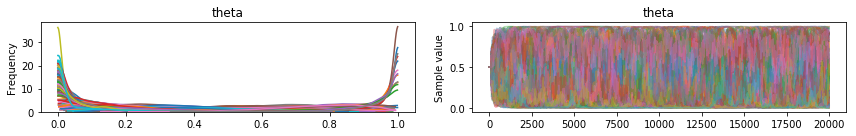

In [17]:
pm.plots.traceplot(trace)

### III. b) YN implementation - Labeling

In [18]:
# Using the parameters estimation from the Training Stage
# as prior parameter for the Labeling Stage

# This is one of the most important parts of the proposed model
theta_val = trace[theta][-5000::20].mean(axis=0)
theta_sd = trace[theta][-5000::20].std(axis=0)

In [19]:
with pm.Model() as model2: 
    
    pi = pm.Dirichlet('pi', p)
    z_unknown = pm.Categorical('z_unknown', p=pi, shape=N_test)
    new_theta = pm.Beta('new_theta', mu=theta_val, sd=theta_sd, shape=(J, K, K))        

    # EQUATION (3.2)
    def likelihood_Pzt_r(value, zt=z_unknown, theta=new_theta, pzs=pi):
        l = np.log(theta[:, zt,:]**value[:,:,:,0] * (1-theta[:,zt,:])**(value[:,:,:,1]))
        return l.sum()
    
    r = pm.DensityDist('r', likelihood_Pzt_r, observed=(r_test))

with model2:   
    step1 = pm.Metropolis([new_theta, pi])
    step2 = pm.CategoricalGibbsMetropolis([z_unknown])
    
    # for full convergence njobs should be about 10.
    # for sppiding up the demo we use njobs=1
    trace2 = pm.sample(3000, step=[step1, step2], njobs=1)

100%|██████████| 3000/3000 [01:10<00:00, 42.68it/s]


In [20]:
print("Credibility part TRUE proportion distribution {}".format(p))
print("Labeling part TRUE proportion distribution {}".format(p_test))
print("Labeling part LEARNED proportion distribution {}".format(trace2[pi][-100::10].mean(axis=0)))

Credibility part TRUE proportion distribution [ 0.34146341  0.2195122   0.17073171  0.26829268]
Labeling part TRUE proportion distribution [ 0.2375  0.2125  0.225   0.325 ]
Labeling part LEARNED proportion distribution [ 0.14760714  0.246984    0.28418146  0.32122739]


In [21]:
# MAP
v, f = stats.mode(trace2[z_unknown][-500::10])
result = v[0]

[[ 0.684  0.158  0.158  0.   ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]


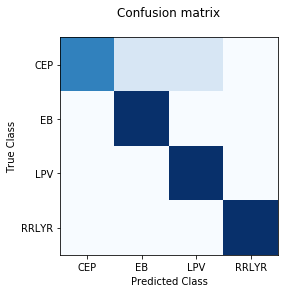

Acurracy score 0.925


Metrics / Classes,CEP,EB,LPV,RRLYR
Precision score,1.0,0.85,0.857,1.0
Recall score,0.684,1.0,1.0,1.0
F score,0.813,0.919,0.923,1.0


In [22]:
draw_metrics(zt_test, result, [classes_dict[i] for i in range(K)])

# IV. ABCD - PYMC IMPLEMENTATION

### IV. a) ABCD implementation - Credibility

In [23]:
votes_abc = pd.read_csv(selected_folder+'votes_abcd.csv')
votes_abc = votes_abc[votes_abc.expert_id.isin(experts)]

In [24]:
# Generatting the ABCD matrix of votes from the source data
def matrix_votes_abcd(J, N, K, o_columns, votes):
    r_ = np.zeros((J, N, K))
    for i in range(o_columns.shape[0]):
        instance = o_columns.iloc[i]
        _votes = votes[votes.object_id == instance.catalina_id]
        for v in range(_votes.shape[0]):
            vote = _votes.iloc[v]
            r_[inv_experts_id[vote.expert_id], i,  inv_classes_dict[vote.value]] = 1
    return r_

In [25]:
# Getting the votes for the users KNOWN LABELS - TRAINING PART
r_true = matrix_votes_abcd(J, N, K, o_columns[o_columns._training], votes_abc)  

In [26]:
crowd_J = J

In [27]:
def get_classes(r):
    return np.array([[_.tolist().index(1) for _ in expert] for expert in r])

crowd_r = get_classes(r_true)

data = np.zeros((crowd_J, K, K))
for i in range(crowd_J):
    data[i] = confusion_matrix(zt, crowd_r[i])
    
norm = np.array((data.reshape((crowd_J*K,K))/np.matrix(data.sum(2).reshape(crowd_J*K)).T)).reshape((crowd_J,K,K))
obs = data.reshape((crowd_J*K,K)).sum(1).reshape((crowd_J,K))

In [28]:
with pm.Model() as model:
    theta = pm.Dirichlet('theta', np.ones(K)/K, shape=(crowd_J*K,K))
    likel = pm.Multinomial('likel', obs.reshape((crowd_J*K)), theta, 
                           observed=data.reshape((crowd_J*K,K)), shape=(crowd_J*K,K))

with model:
    step = pm.Metropolis([theta,likel])
    trace = pm.sample(20000, step)

100%|██████████| 20000/20000 [00:05<00:00, 3523.49it/s]


### IV. b) ABCD implementation - Labeling

In [29]:
r_test = matrix_votes_abcd(J, N_test, K, o_columns[~o_columns._training], votes_abc)  

In [30]:
theta_val = trace[theta][-5000::20].mean(axis=0).reshape((crowd_J,K,K))
theta_val= np.array((theta_val.reshape((crowd_J*K,K))/np.matrix(theta_val.sum(2).reshape(crowd_J*K)).T)).reshape((crowd_J,K,K))
theta_sd = trace[theta][-5000::20].std(axis=0).reshape((crowd_J,K,K))

In [31]:
crowd_r_u = get_classes(r_test)

In [32]:
crowd_r_u = get_classes(r_test)

data_test = np.zeros((crowd_J, K, K))
for i in range(crowd_J):
    data_test[i] = confusion_matrix(zt_test, crowd_r_u[i])
data_test

norm_test = np.array((data_test.reshape((crowd_J*K,K))/np.matrix(data_test.sum(2).reshape(crowd_J*K)).T)).reshape((crowd_J,K,K))
obs_test = data_test.reshape((crowd_J*K,K)).sum(1).reshape((crowd_J,K))

In [34]:
with pm.Model() as model2: 
    pi = pm.Dirichlet('pi', p)
    
    z_unknown = pm.Categorical('z_unknown', p=pi, shape=(N_test))

    new_theta = pm.Dirichlet('theta', theta_val, shape=(crowd_J,K,K))

    def likelihood_Pzt_r(value, zt=z_unknown, theta=new_theta, pzs=pi):
        l = np.log(theta[:, zt,:]**value)
        return l.sum()

    r = pm.DensityDist('r', likelihood_Pzt_r, observed=(r_test))

with model2:
    step0 = pm.Slice(pi)
    step1 = pm.Metropolis([new_theta])
    step2 = pm.CategoricalGibbsMetropolis([z_unknown])
    trace2 = pm.sample(5000, step=[step0, step1, step2], njobs=1)

100%|██████████| 5000/5000 [02:06<00:00, 39.47it/s]


In [38]:
p_test = Ns_test/ Ns_test.sum()
p, p_test, trace2[pi][1000::10].mean(axis=0)

(array([ 0.34146341,  0.2195122 ,  0.17073171,  0.26829268]),
 array([ 0.2375,  0.2125,  0.225 ,  0.325 ]),
 array([ 0.14042533,  0.26713698,  0.26780912,  0.32462857]))

In [39]:
_trace = trace2.get_values('z_unknown', chains=0)
v, f = stats.mode(_trace[1000::10], 0)
result = v.T

[[ 0.579  0.211  0.158  0.053]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]


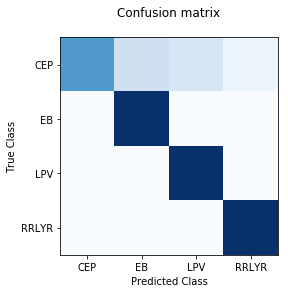

Acurracy score 0.9


Metrics / Classes,CEP,EB,LPV,RRLYR
Precision score,1.0,0.81,0.857,0.963
Recall score,0.579,1.0,1.0,1.0
F score,0.733,0.895,0.923,0.981


In [41]:
draw_metrics(zt_test, result, [classes_dict[i] for i in range(K)])